In [1]:
import os
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)
plt.ion()

import Corrfunc
from Corrfunc.io import read_lognormal_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.DD import DD
from Corrfunc.theory.xi import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import qq_analytic
from Corrfunc.bases import spline

%load_ext autoreload
%autoreload 2

In [2]:
Corrfunc.__file__

'/Users/abbywilliams/opt/anaconda3/lib/python3.7/site-packages/Corrfunc/__init__.py'

In [3]:
Corrfunc.__version__

'0.0.5'

## Load in data

In [4]:
x, y, z = read_lognormal_catalog(n='1e-4')
boxsize = 750.0
nd = len(x)
print("Number of data points:",nd)

Number of data points: 43000


In [5]:
nr = 3*nd
x_rand = np.random.uniform(0, boxsize, nr)
y_rand = np.random.uniform(0, boxsize, nr)
z_rand = np.random.uniform(0, boxsize, nr)
print("Number of random points:",nr)

Number of random points: 129000


In [6]:
print(x)
print(x_rand)

[1.13136184e+00 4.30035293e-01 2.08324015e-01 ... 7.48871826e+02
 7.49930237e+02 7.49063599e+02]
[302.94824289 257.71467152 642.43802844 ... 725.33241321 431.69854036
 669.09878964]


In [7]:
rmin = 40.0
rmax = 150.0
nbins = 22
r_edges = np.linspace(rmin, rmax, nbins+1)
r_avg = 0.5*(r_edges[1:]+r_edges[:-1])

periodic = True
nthreads = 1

In [8]:
dd_res = DD(1, nthreads, r_edges, x, y, z, boxsize=boxsize, periodic=periodic)
dr_res = DD(0, nthreads, r_edges, x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand, boxsize=boxsize, periodic=periodic)
rr_res = DD(1, nthreads, r_edges, x_rand, y_rand, z_rand, boxsize=boxsize, periodic=periodic)

In [9]:
def landy_szalay(nd, nr, dd, dr, rr):
    # Normalize the pair counts
    dd = dd/(nd*nd)
    dr = dr/(nd*nr)
    rr = rr/(nr*nr)
    xi_ls = (dd-2*dr+rr)/rr
    return xi_ls

In [10]:
dd = np.array([x['npairs'] for x in dd_res], dtype=float)
dr = np.array([x['npairs'] for x in dr_res], dtype=float)
rr = np.array([x['npairs'] for x in rr_res], dtype=float)
xi_ls = landy_szalay(nd, nr, dd, dr, rr)

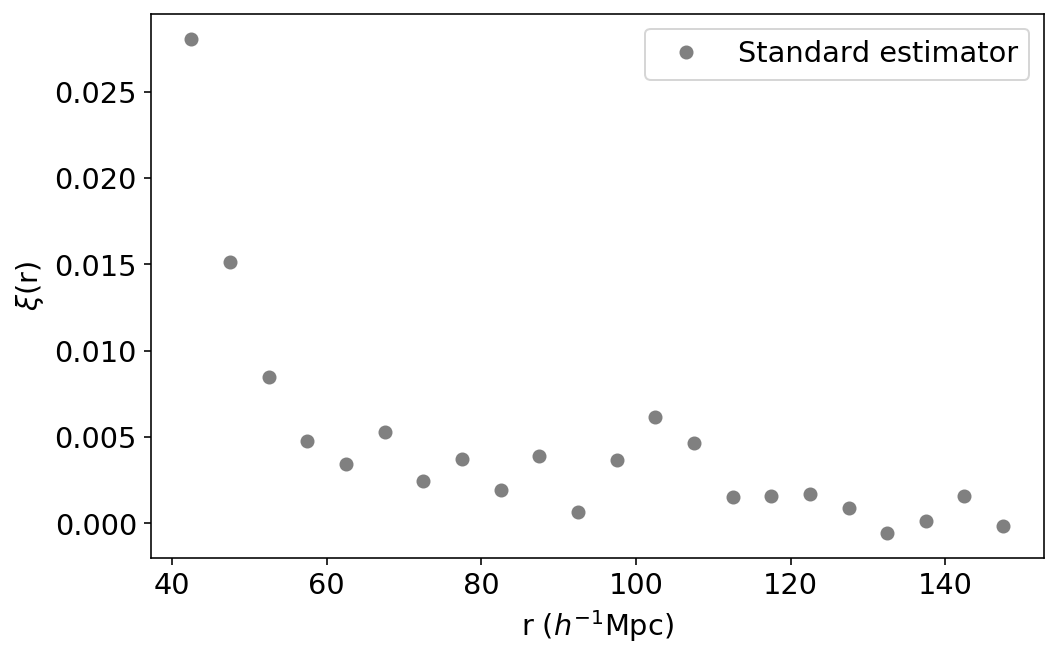

In [11]:
plt.figure(figsize=(8,5))
plt.plot(r_avg, xi_ls, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

## Continuous-function estimator: Tophat bias

In [12]:
proj_type = 'tophat'
nprojbins = nbins

In [13]:
nmubins = 1
mumax = 1.0

In [14]:
dd_res, dd_proj, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, nprojbins=nprojbins)

In [15]:
dr_res, dr_proj, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand,
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, nprojbins=nprojbins)

In [16]:
rr_res, rr_proj, qq_proj = DDsmu(1, nthreads, r_edges, mumax, nmubins, x_rand, y_rand, z_rand,
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, nprojbins=nprojbins)

In [17]:
amps = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)

Computing amplitudes (Corrfunc/utils.py)


In [18]:
r_fine = np.linspace(rmin, rmax, 2000)

In [20]:
xi_proj = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges)

Evaluating xi (Corrfunc/utils.py)


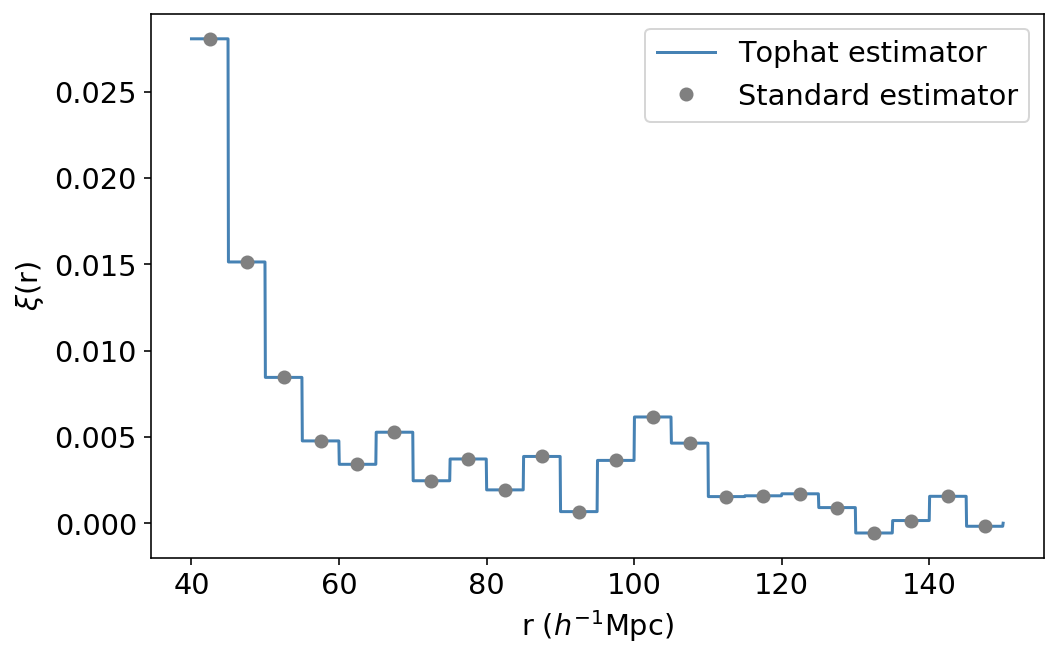

In [21]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_proj, color='steelblue', label='Tophat estimator')
plt.plot(r_avg, xi_ls, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

### Analytically computing the random term

In [23]:
volume = boxsize**3
rr_ana, qq_ana = qq_analytic(rmin, rmax, nd, volume, nprojbins, proj_type, rbins=r_edges)

Evaluating qq_analytic (Corrfunc/utils.py)


In [24]:
numerator = dd_proj - rr_ana
amps_ana = np.linalg.solve(qq_ana, numerator) # Use linalg.solve instead of actually computing inverse!

In [25]:
xi_ana = evaluate_xi(amps_ana, r_fine, proj_type, rbins=r_edges)

Evaluating xi (Corrfunc/utils.py)


In [26]:
xi_res = Corrfunc.theory.xi(boxsize, nthreads, r_edges, x, y, z)
xi_theory = np.array([x['xi'] for x in xi_res], dtype=float)

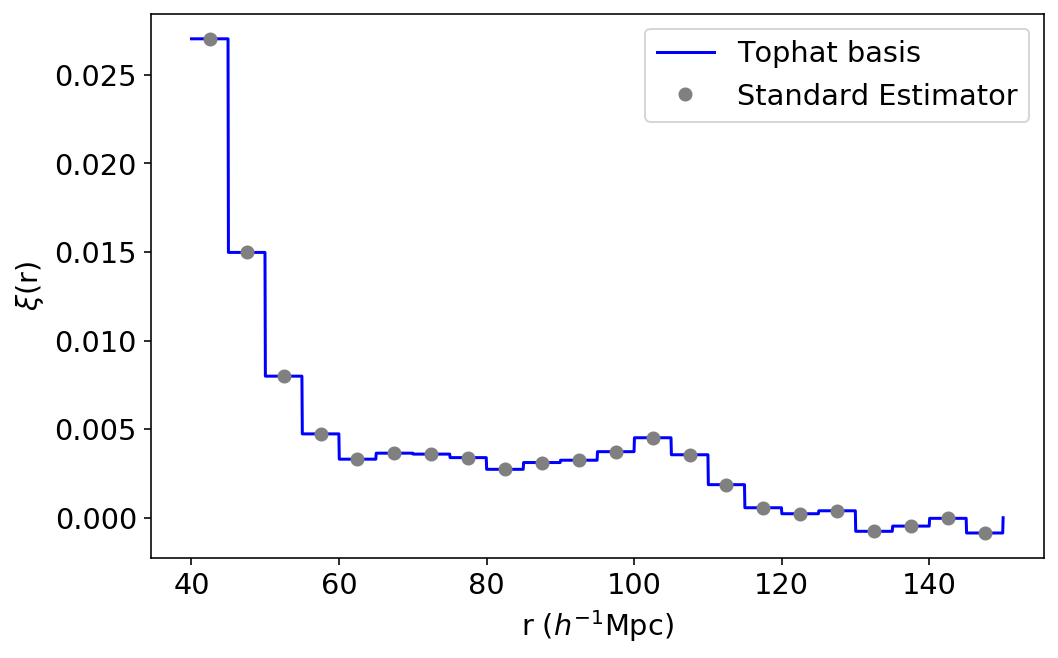

In [27]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana, color='blue', label='Tophat basis')
plt.plot(r_avg, xi_theory, marker='o', ls='None', color='grey', label='Standard Estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

## Continuous-function estimator: Cubic spline basis

In [28]:
proj_type = 'generalr'
kwargs = {'order': 3} # 3: cubic spline
projfn = 'quadratic_spline.dat'
nprojbins = int(nbins/2)
spline.write_bases(rmin, rmax, nprojbins, projfn, ncont=1000, **kwargs)

'quadratic_spline.dat'

Text(0.5, 0, 'r ($h^{-1}$Mpc)')

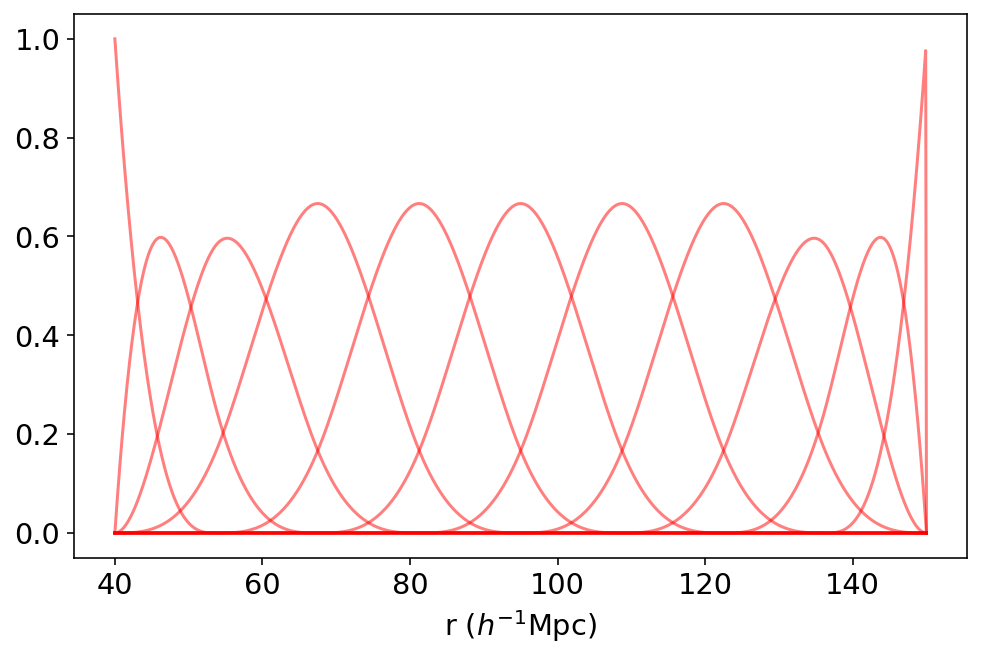

In [29]:
bases = np.loadtxt(projfn)
bases.shape
r = bases[:,0]
plt.figure(figsize=(8,5))
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i], color='red', alpha=0.5)
plt.xlabel(r'r ($h^{-1}$Mpc)')

In [31]:
dd_res_spline, dd_spline, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn)

In [32]:
volume = boxsize**3
# nbins and r_edges won't be used here because we passed projfn, but they're needed for compatibility. (TODO: fix!)
rr_ana_spline, qq_ana_spline = qq_analytic(rmin, rmax, nd, volume, nprojbins, proj_type, rbins=r_edges, projfn=projfn)

numerator = dd_spline - rr_ana_spline
amps_ana_spline = np.linalg.solve(qq_ana_spline, numerator) # Use linalg.solve instead of actually computing inverse!

xi_ana_spline = evaluate_xi(amps_ana_spline, r_fine, proj_type, rbins=r_edges, projfn=projfn)

Evaluating qq_analytic (Corrfunc/utils.py)
Evaluating xi (Corrfunc/utils.py)


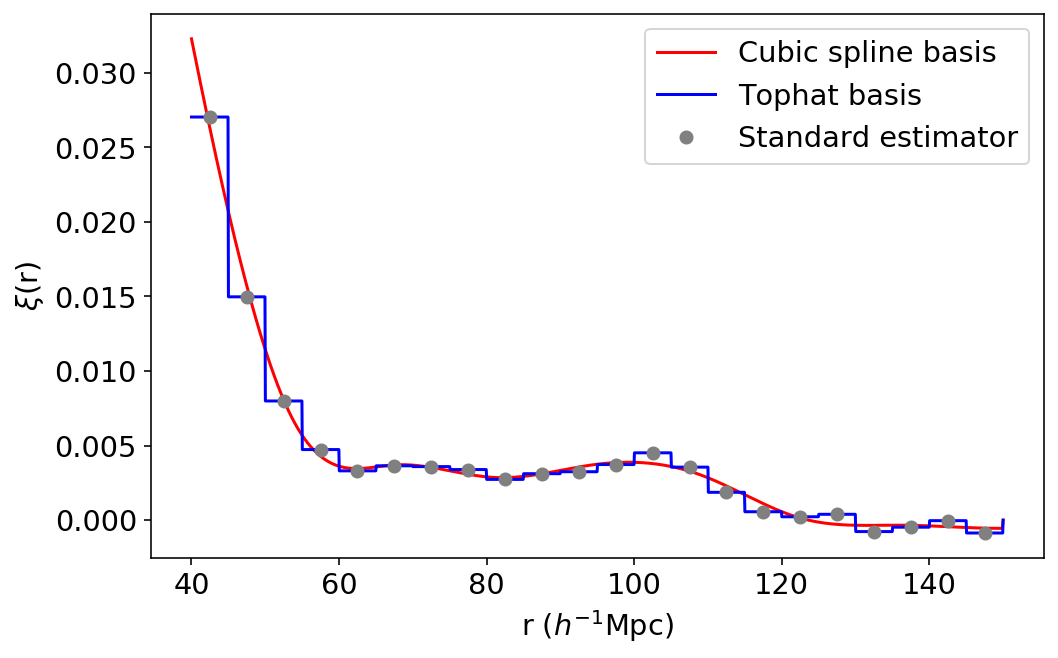

In [33]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana_spline, color='red', label='Cubic spline basis')
plt.plot(r_fine, xi_ana, color='blue', label='Tophat basis')
plt.plot(r_avg, xi_theory, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

## Zero order spline basis

In [ ]:
proj_type = 'generalr'
kwargs = {'order': 0} # 0: zero order spline
projfn = 'quadratic_spline.dat'
nprojbins = int(nbins/1)
spline.write_bases(rmin, rmax, nprojbins, projfn, ncont=1000, **kwargs)

In [ ]:
bases = np.loadtxt(projfn)
bases.shape
r = bases[:,0]
plt.figure(figsize=(8,5))
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i], color='red', alpha=0.5)
plt.xlabel(r'r ($h^{-1}$Mpc)')

In [ ]:
dd_res_spline, dd_spline, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, boxsize=boxsize, periodic=periodic, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn)

In [ ]:
volume = boxsize**3
# nbins and r_edges won't be used here because we passed projfn, but they're needed for compatibility. (TODO: fix!)
rr_ana_spline, qq_ana_spline = qq_analytic(rmin, rmax, nd, volume, nprojbins, nbins, r_edges, proj_type, projfn=projfn)

numerator = dd_spline - rr_ana_spline
amps_ana_spline, *_ = np.linalg.lstsq(qq_ana_spline, numerator, rcond=None) # Use linalg.lstsq instead of actually computing inverse!

xi_ana_spline = evaluate_xi(nprojbins, amps_ana_spline, len(r_fine), r_fine, nbins, r_edges, proj_type, projfn=projfn)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana_spline, color='red', label='Linear spline basis')
plt.plot(r_fine, xi_ana, color='blue', label='Tophat basis')
plt.plot(r_avg, xi_theory, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

## Linear spline basis

In [ ]:
proj_type = 'generalr'
kwargs = {'order': 1} # 1: linear spline
projfn = 'quadratic_spline.dat'
nprojbins = int(nbins/1)
spline.write_bases(rmin, rmax, nprojbins, projfn, ncont=1000, **kwargs)

In [ ]:
bases = np.loadtxt(projfn)
bases.shape
r = bases[:,0]
plt.figure(figsize=(8,5))
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i], color='red', alpha=0.5)
plt.xlabel(r'r ($h^{-1}$Mpc)')

In [ ]:
dd_res_spline, dd_spline, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, boxsize=boxsize, periodic=periodic, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn)

In [ ]:
volume = boxsize**3
# nbins and r_edges won't be used here because we passed projfn, but they're needed for compatibility. (TODO: fix!)
rr_ana_spline, qq_ana_spline = qq_analytic(rmin, rmax, nd, volume, nprojbins, nbins, r_edges, proj_type, projfn=projfn)

numerator = dd_spline - rr_ana_spline
amps_ana_spline, *_ = np.linalg.lstsq(qq_ana_spline, numerator, rcond=None) # Use linalg.lstsq instead of actually computing inverse!

xi_ana_spline = evaluate_xi(nprojbins, amps_ana_spline, len(r_fine), r_fine, nbins, r_edges, proj_type, projfn=projfn)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana_spline, color='red', label='Linear spline basis')
plt.plot(r_fine, xi_ana, color='blue', label='Tophat basis')
plt.plot(r_avg, xi_theory, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

## Quadratic spline basis

In [ ]:
proj_type = 'generalr'
kwargs = {'order': 2} # 2: quadratic spline
projfn = 'quadratic_spline.dat'
nprojbins = int(nbins/2)
spline.write_bases(rmin, rmax, nprojbins, projfn, ncont=1000, **kwargs)

In [ ]:
bases = np.loadtxt(projfn)
bases.shape
r = bases[:,0]
plt.figure(figsize=(8,5))
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i], color='red', alpha=0.5)
plt.xlabel(r'r ($h^{-1}$Mpc)')

In [ ]:
dd_res_spline, dd_spline, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, boxsize=boxsize, periodic=periodic, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn)

In [ ]:
volume = boxsize**3
# nbins and r_edges won't be used here because we passed projfn, but they're needed for compatibility. (TODO: fix!)
rr_ana_spline, qq_ana_spline = qq_analytic(rmin, rmax, nd, volume, nprojbins, nbins, r_edges, proj_type, projfn=projfn)

numerator = dd_spline - rr_ana_spline
amps_ana_spline, *_ = np.linalg.lstsq(qq_ana_spline, numerator, rcond=None) # Use linalg.lstsq instead of actually computing inverse!

xi_ana_spline = evaluate_xi(nprojbins, amps_ana_spline, len(r_fine), r_fine, nbins, r_edges, proj_type, projfn=projfn)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana_spline, color='red', label='Quadratic spline basis')
plt.plot(r_fine, xi_ana, color='blue', label='Tophat basis')
plt.plot(r_avg, xi_theory, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

In [ ]:
os.remove(projfn)

In [ ]:
#!jupyter nbconvert --to script example_theory.ipynb